---
title: "Token Classification with DeBERTa"
date: "2022-09-20"
image: "image.png"
format:
  html:
    code-fold: true
    code-line-numbers: false
jupyter: python3
---

In the recent [Feedback Prize - Predicting Effective Arguments](https://www.kaggle.com/competitions/feedback-prize-effectiveness/overview) competition on Kaggle, the task was to automatically rate the quality of argumentative elements in student writing based on some 4,000 essays that had been annotated by human experts and provided by the competition hosts. Since it is quite interesting how language models can be trained to handle this task effectively, here is a quick rundown describing the token classification approach that was commonly used in the competition.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold

import torch
from transformers import AutoConfig, AutoTokenizer, AutoModelForTokenClassification 
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForTokenClassification
from datasets import Dataset

import spacy
from spacy import displacy

import codecs
from text_unidecode import unidecode

import re
from pathlib import Path

import os
import gc

In [3]:
train_df = pd.read_csv("train.csv")

## The Training Data

Let's begin by having a look at the training data which consists of 4,191 essays containing a total of 36,765 so-called discourse texts (i.e., argumentative elements of an essay). These discourse texts have been labeled by human annotators as one of seven discourse types (lead, position, claim, counterclaim, rebuttal, evidence, or concluding statement) and rated as either ineffective, adequate, or effective. While the discourse type will be available at test time, the task of the model will be to predict the quality rating.



In [5]:
print("Number of discourse texts:", train_df.discourse_id.unique().shape[0])
print("Number of essays:", train_df.essay_id.unique().shape[0])

Number of discourse texts: 36765
Number of essays: 4191


We won't do thorough EDA, but take a quick look at some aggregate statistics.

Naturally, some discourse types (like claim and evidence) occur more often than others (e.g., the ones that only occur at the beginning or at the end of an essay). Counterclaim and rebuttal are the least common labels.

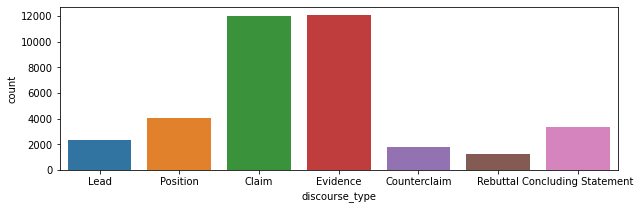

In [6]:
_, ax = plt.subplots(figsize=(10, 3))
sns.countplot(data=train_df, x="discourse_type", ax=ax);

The most common rating is "adequate" with "effective" coming in second and "ineffective" third.

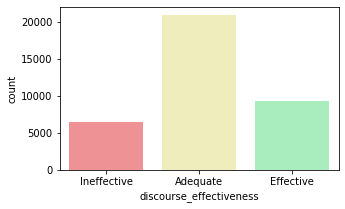

In [7]:
effectiveness_colors = {"Ineffective": "#ff8286", "Adequate": "#f7f5b2", "Effective": "#9ef7b8"}
effectiveness_order = ["Ineffective", "Adequate", "Effective"]
_, ax = plt.subplots(figsize=(5, 3))
sns.countplot(data=train_df, x="discourse_effectiveness", ax=ax, palette=effectiveness_colors, order=effectiveness_order);

In [8]:
def get_essay_by_id(essay_id):
    with open(f"{base_path}/train/{essay_id}.txt", "r") as f:
        essay = f.read()
    return essay

def display_essay(essay_id):
    essay = get_essay_by_id(essay_id)
    ents = []
    color_map = {"Ineffective": "#ff8286", "Adequate": "#f7f5b2", "Effective": "#9ef7b8"}
    colors = {}
    for _, row in train_df.loc[train_df.essay_id == essay_id].iterrows():
        segment, label, rating = row.discourse_text, row.discourse_type, row.discourse_effectiveness
        start, end = re.search(segment.strip(), essay).span()
        ent = f"{label} - {rating}"
        ents.append({
            "start": start,
            "end": end,
            "label": ent
        })
        if ent not in colors:
            colors[ent] = color_map[rating]
            
    ann = {
        "text": essay,
        "ents": ents
    }
    options = {
        "colors": colors
    }
    displacy.render(ann, style="ent", manual=True, jupyter=True, options=options)

We can use spacy's [`displacy` visualizer](https://spacy.io/usage/visualizers) to display essays annotated with the discourse type labels and color-coded ratings:

In [9]:
display_essay("8727FFFF8441")


Note that an essay doesn't necessarily contain all discourse types:

In [10]:
by_essay_id = train_df.groupby(["essay_id"]).discourse_type.value_counts().to_frame()
by_essay_id.columns = ["count_"]
by_essay_id.reset_index(drop=False, inplace=True)
by_essay_id = by_essay_id.pivot(index="essay_id", columns="discourse_type").count_
by_essay_id

discourse_type,Claim,Concluding Statement,Counterclaim,Evidence,Lead,Position,Rebuttal
essay_id,,,,,,,
00066EA9880D,3.0,1.0,NaN,3.0,1.0,1.0,NaN
000E6DE9E817,5.0,1.0,1.0,3.0,NaN,1.0,1.0
0016926B079C,7.0,NaN,NaN,3.0,NaN,1.0,NaN
00203C45FC55,1.0,1.0,3.0,3.0,1.0,1.0,3.0
0029F4D19C3F,2.0,1.0,1.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
FFA381E58FC6,2.0,1.0,NaN,1.0,NaN,1.0,NaN
FFC43F453EF6,4.0,1.0,3.0,1.0,NaN,1.0,1.0
FFD97A99CEBA,NaN,NaN,NaN,1.0,NaN,NaN,NaN


Also, as it is usually the case with human-labeled datasets, the quality of the annotations can vary significantly between essays. While an essay on average contains almost 9 different discourse elements, there are quite a few essays with only one annotation that has been rated as a whole:

In [11]:
display_essay("AB02689C1A9B")

Finally, the same discourse text can appear in different essays, belong to different discourse types, and have different effectiveness ratings:

In [12]:
duplicates = train_df[train_df.discourse_text.duplicated(keep=False)].sort_values(by="discourse_text")
duplicates.head(25)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
26691,7f9c3500259d,A602D45D22B2,"""That's a lava dome that takes the form of an ...",Evidence,Adequate
27350,d628a6adda3a,ADB68BCD2874,"""That's a lava dome that takes the form of an ...",Evidence,Adequate
25391,781452d9404c,942ECB176B3A,"At the most basic level, the electoral college...",Position,Adequate
28835,6fa171a95540,C2BAF4ADA2CA,"At the most basic level, the electoral college...",Claim,Adequate
28436,9e12ec699196,BB3A6C2D0B65,Big States,Claim,Adequate
20121,35bf70c4a673,4CA37D113612,Big States,Claim,Ineffective
3933,c5b2ecb3888e,44E2726DA1B3,I agree,Position,Adequate
11285,5e4022e93247,CB66B685DAF6,I agree,Position,Adequate
17087,99782ca26927,2714214F7D9E,I think students should be required to perform...,Position,Adequate
29590,33d6bbba823c,CE64FA08E4CF,I think students should be required to perform...,Position,Adequate


This indicates that context will matter a lot, i.e. the model will need the entire essay instead of the discourse text segment alone in order to make good predictions.

## The Model

Now the question is, how can we frame the task so that it can be handled by a language model? Or, to be more precise, how can we design the input? One possible approach is defining the problem as text classification by doing something like this:

```discourse type: discourse text SEP essay text```

Although this may work relatively fine, there is a problem. This approach requires one forward pass for each discourse text in the dataset, and the context isn't used as effectively as it could be. Thus, it was [proposed](https://www.kaggle.com/code/nbroad/token-classification-approach-fpe#Training) to frame the problem as token classification instead of text classification. That is, we'll use the entire essay and wrap each discourse text segment in corresponding `CLS` and `END` tokens (e.g., `CLS_LEAD` and `END_LEAD`). Apart from faster training, this approach will likely improve the model's understanding of the context of each discourse segment. To compute the class scores we'll only use the output of the classification head at the `CLS` tokens.

Let's see how this works out in code.

### Tokenization

Let's begin by loading the full text for each essay and including it in our existing `train_df` dataframe. Note that we need to solve encoding issues before we can tokenize the dataset.

In [13]:
# helper functions for fixing potential encoding errors
def replace_encoding_with_utf8(error):
    return error.object[error.start : error.end].encode("utf-8"), error.end

def replace_decoding_with_cp1252(error):
    return error.object[error.start : error.end].decode("cp1252"), error.end

codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text):
    text = (
        text.encode("raw_unicode_escape")
            .decode("utf-8", errors="replace_decoding_with_cp1252")
            .encode("cp1252", errors="replace_encoding_with_utf8")
            .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

# retrieves the full text of an essay
def get_essay_text(example):
    essay_id = example["essay_id"]
    with open(base_path/"train"/f"{essay_id}.txt", "r") as f:
        example["essay_text"] = resolve_encodings_and_normalize(f.read())
    return example

In [14]:
#| output: false
train_df = pd.read_csv(base_path/"train.csv")
essay_ds = Dataset.from_dict({
    "essay_id": train_df.essay_id.unique()
})
essay_ds = essay_ds.map(
    get_essay_text,
    num_proc=2,
    batched=False,
    desc="Loading essay texts"
)
essay_df = essay_ds.to_pandas()

Loading essay texts #0:   0%|          | 0/2096 [00:00<?, ?ex/s]

Loading essay texts #1:   0%|          | 0/2095 [00:00<?, ?ex/s]

In [ ]:
train_df["discourse_text"] = train_df["discourse_text"].apply(resolve_encodings_and_normalize)
train_df = train_df.merge(essay_df, on="essay_id", how="left")

After defining the custom tokens, we can load the tokenizer and register them using the `add_special_tokens` method:

In [16]:
#| code-fold: show
dtype_classes = ["Claim", "Concluding Statement", "Counterclaim", "Evidence", "Lead", "Position", "Rebuttal"]
dtype2clstok = {dtype: f"[CLS_{dtype.upper()}]" for dtype in dtype_classes}
dtype2endtok = {dtype: f"[END_{dtype.upper()}]" for dtype in dtype_classes}

dtype2clstok

{'Claim': '[CLS_CLAIM]',
 'Concluding Statement': '[CLS_CONCLUDING STATEMENT]',
 'Counterclaim': '[CLS_COUNTERCLAIM]',
 'Evidence': '[CLS_EVIDENCE]',
 'Lead': '[CLS_LEAD]',
 'Position': '[CLS_POSITION]',
 'Rebuttal': '[CLS_REBUTTAL]'}

In [17]:
#| code-fold: show
MODEL_CKPT = "microsoft/deberta-v3-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)
tokenizer.add_special_tokens(
    {"additional_special_tokens": list(dtype2clstok.values()) + list(dtype2endtok.values())}
)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

14

Note that we need to save the input id used by the tokenizer for each `CLS` token, so that we can set all other tokens to `-100`.

In [18]:
#| code-fold: show
dtype2clstokid = {dtype: tokenizer.encode(tok)[1] for dtype, tok in dtype2clstok.items()}
dtype2clstokid

{'Claim': 128001,
 'Concluding Statement': 128002,
 'Counterclaim': 128003,
 'Evidence': 128004,
 'Lead': 128005,
 'Position': 128006,
 'Rebuttal': 128007}

Now to the most important function. `tokenize` inserts the custom tokens at the appropriate positions into an essay and returns the entire tokenized text.

In [19]:
# gets the start and end index for each discourse_text in an essay
def get_positions(example):

    essay_text = example["essay_text"][0]
    cur_idx = 0
    idxs = []
    
    # loop over all discourse texts in the essay
    for dt in example["discourse_text"]:
        matches = list(re.finditer(re.escape(dt.strip()), essay_text))
        if len(matches) > 1:
            for m in matches:
                if m.start() >= cur_idx:
                    break
        elif len(matches) == 0:
            idxs.append([-1])
            continue  
        else:
            m = matches[0]
            
        idxs.append([m.start(), m.end()])
        cur_idx = m.start()

    return idxs

label2id = {
    "Adequate": 0,
    "Effective": 1,
    "Ineffective": 2
}

def tokenize(example):
    example["idxs"] = get_positions(example)
    essay_text = example["essay_text"][0]
    
    segments = []
    labels = []
    prev_end = 0

    for idxs, dtype, label in zip(example["idxs"], 
                                  example["discourse_type"],
                                  example["discourse_effectiveness"]):
        if idxs == [-1]:
            continue
        
        start, end = idxs
        if start != prev_end:
            segments.append(essay_text[prev_end:start])
            prev_end = start
        if start == prev_end:
            segments.append(dtype2clstok[dtype])
            segments.append(essay_text[start:end])
            segments.append(dtype2endtok[dtype])
        prev_end = end
            
        labels.append(label2id[label])

    tokenized = tokenizer(" ".join(segments),
                          padding=False,
                          truncation=True,
                          max_length=2048,
                          add_special_tokens=True)
    
    # add -100 labels for each token except for the CLS tokens
    # -100 labels will be ignored by the loss function
    idx = 0
    labels_final = []
    for id_ in tokenized["input_ids"]:
        if id_ in dtype2clstokid.values():
            labels_final.append(labels[idx])
            idx += 1
        else:
            labels_final.append(-100)
    
    tokenized["labels"] = labels_final
    
    return tokenized

To tokenize the entire dataset, we'll first create a `Dataset` with the training date grouped by `essay_id` to loop over all `discourse_text` contained in the text. Then we'll use the `map()` method to tokenize each essay:

In [20]:
#| code-fold: show
train_df_by_id = train_df.groupby(["essay_id"]).agg(list)
ds = Dataset.from_pandas(train_df_by_id)

In [21]:
#| code-fold: show
#| output: false
ds = (ds.map(tokenize, batched=False, num_proc=2, desc="Tokenizing")
        .remove_columns(["discourse_id", "discourse_text", "discourse_type", "essay_text", "essay_id"]))

Tokenizing #0:   0%|          | 0/2096 [00:00<?, ?ex/s]

Tokenizing #1:   0%|          | 0/2095 [00:00<?, ?ex/s]

In [22]:
ds.save_to_disk("tokenized.dataset")

Let's look at an example to see whether we did everything correctly:

In [23]:
#| code-fold: show
example_tokens = tokenizer.convert_ids_to_tokens(ds[0]["input_ids"])
example_string = tokenizer.convert_tokens_to_string(example_tokens)
example_string

"[CLS][CLS_LEAD] Driverless cars are exaclty what you would expect them to be. Cars that will drive without a person actually behind the wheel controlling the actions of the vehicle. The idea of driverless cars going in to developement shows the amount of technological increase that the wolrd has made. The leader of this idea of driverless cars are the automobiles they call Google cars. The arduous task of creating safe driverless cars has not been fully mastered yet.[END_LEAD][CLS_POSITION] The developement of these cars should be stopped immediately because there are too many hazardous and dangerous events that could occur.[END_POSITION] One thing that the article mentions is that[CLS_CLAIM] the driver will be alerted when they will need to take over the driving responsibilites of the car.[END_CLAIM][CLS_EVIDENCE] This is such a dangerous thing because we all know that whenever humans get their attention drawn in on something interesting it is hard to draw their focus somewhere else.

Looks good.

### Fine-tuning DeBERTa

Since models of the DeBERTa family are generally the best default choice in English language tasks, we'll use the `microsoft/deberta-v3-small` checkpoint from the HuggingFace Hub and train it for three epochs.

While we would normally employ a cross-validation scheme that validates on essay topics that the model hasn't seen during training, we'll stick to a very simple train test split for our demonstration purposes.

In [24]:
dds = ds.train_test_split(test_size=0.2)
dds

DatasetDict({
    train: Dataset({
        features: ['discourse_effectiveness', 'idxs', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3352
    })
    test: Dataset({
        features: ['discourse_effectiveness', 'idxs', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 839
    })
})

In [25]:
TRAINING_ARGS = {
    "learning_rate": 9e-6,
    "num_train_epochs": 3,
    "weight_decay": 0.01,
    "warmup_ratio": 0.1,
    "per_device_train_batch_size": 4,
    "per_device_eval_batch_size": 4,
    "fp16": True,
    "optim": "adamw_torch",
    "do_train": True,
    "do_eval": True,
    "logging_steps": 50,
    "save_strategy": "epoch",
    "evaluation_strategy": "epoch",
    "save_total_limit": 1,
    "group_by_length": True,
    "save_total_limit": 1,
    "metric_for_best_model": "loss",
    "greater_is_better": False,
    "gradient_checkpointing": True,
    "gradient_accumulation_steps": 1,
    "output_dir": "../output/"
}

In [ ]:
#| code-fold: show
args = TrainingArguments(**TRAINING_ARGS)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer,
                                                   pad_to_multiple_of=8,
                                                   padding=True)

In [26]:
#| code-fold: show
model_config = AutoConfig.from_pretrained(MODEL_CKPT)
model_config.update({
    "num_labels": 3,
    "cls_tokens": list(dtype2clstok.values()),
    "label2id": label2id,
    "id2label": {v: k for k, v in label2id.items()}
})

In [27]:
#| code-fold: show
#| output: false
model = AutoModelForTokenClassification.from_pretrained(MODEL_CKPT, config=model_config)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Since we added custom tokens, we have to resize the token embeddings:

In [28]:
#| code-fold: show
model.resize_token_embeddings(len(tokenizer))

Embedding(128015, 768)

In [29]:
#| code-fold: show
trainer = Trainer(model=model,
                  args=args,
                  train_dataset=dds["train"],
                  eval_dataset=dds["test"],
                  tokenizer=tokenizer,
                  data_collator=data_collator)

Having set up the trainer, everything looks fine:

In [30]:
#| code-fold: show
trainer.evaluate()

{'eval_loss': 1.0528874397277832,
 'eval_runtime': 26.0332,
 'eval_samples_per_second': 32.228,
 'eval_steps_per_second': 8.067}

In [31]:
#| code-fold: show
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.720800,0.847753
2,0.714600,0.703775
3,0.622000,0.687999


TrainOutput(global_step=2514, training_loss=0.7359402344733263, metrics={'train_runtime': 924.097, 'train_samples_per_second': 10.882, 'train_steps_per_second': 2.72, 'total_flos': 1283172806215872.0, 'train_loss': 0.7359402344733263, 'epoch': 3.0})

And that's it! We've finetuned a small DeBERTa model to predict the quality of discourse elements in student essays.